# Correlations between past and future data metrics

Sandbox/brainstorm notebook for testing descriptive statistics of the truth data.

In [47]:
# -------------------------
# Imports and general setup
import glob
import importlib
import os

os.chdir("..")

import ipywidgets as widgets
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import os
import pandas as pd
import plotly_express as px
import sys

import epiweeks

sys.path.append("../../../Rtrend_project/")

# Rtrend v0 modules
from rtrend_tools.data_io import load_forecast_cdc, load_cdc_truth_data
from rtrend_tools.visualization import rotate_ax_labels

# Rtrend 1.0 modules
from rtrend_forecast.preprocessing import apply_lowpass_filter_pdseries
from rtrend_forecast.rt_estimation import run_mcmc_rt_c
from rtrend_forecast.structs import RtData

# ------

%matplotlib notebook

In [2]:
# ------------
# AUX FUNCTIONS

def calc_one_crossings(sr):
    ft = (sr - 1.0)  # f(t) = sr(t) - 1.0
    mask = (ft.iloc[1:].values * ft.iloc[:-1].values) < 0.  # Find changes in signal of f(t) = R(t) - 1
#     mask_sr = pd.Series(mask, index=)  # Takes the day following a zero-crossing
    crossing_dates = ft.index[1:][mask]
    
    return crossing_dates

def calc_one_crossings_toplot(sr):

    crossing_dates = calc_one_crossings(sr)
    xpts = np.repeat(crossing_dates.to_numpy()[np.newaxis, :], 2, axis=0)
    ypts = np.repeat([[0.5,], [2.0,]], crossing_dates.shape[0], axis=1)
    
    return xpts, ypts

In [3]:
# ----------------
# MAIN IMPORTS

# -------------
# Load truth file
truth_file = "hosp_data/daily_truth-Incident Hospitalizations.csv"
# truth_file = "hosp_data/truth-Incident Hospitalizations.csv"

cdc = load_cdc_truth_data(truth_file)

# -------------
# Load population data
pop_df = pd.read_csv("population_data/locations.csv", index_col=2)  # Col 2 = location_name

cdc.df

<class 'rtrend_tools.forecast_structs.CDCDataBunch'>


location_name  value
date       location                       
2019-12-31 01               Alabama    NaN
           15                Hawaii    NaN
           18               Indiana    NaN
           22             Louisiana    NaN
           27             Minnesota    NaN
...                             ...    ...
2023-05-29 55             Wisconsin    0.0
           56               Wyoming    0.0
           72           Puerto Rico    2.0
           78        Virgin Islands    0.0
           US                    US  115.0

[64332 rows x 2 columns]

## MCMC for the Flu season

In [4]:
roi_start = pd.Timestamp("2022-07-25")
roi_end   = pd.Timestamp("2023-03-02")

state_name = "Nebraska"
rerun_mcmc = False  # False loads precalculated files
tg_shape, tg_rate, tg_max = 10., 10./3, 30

cutoff = 0.05

mcmc_dir = f"season_mcmc/cutoff{cutoff:0.3f}".replace(".", "p")


# -------------
sn = state_name.replace(" ", "_")  # State name without spaces

# --- Collect required infrastructure for the MCMC
state_sr = cdc.xs_state(state_name)["value"].loc[roi_start:roi_end]
roi_len = state_sr.shape[0]
tg_shaperate_array = np.repeat([[tg_shape, tg_rate]], roi_len, axis=0)

tg_shaperate_array

# --- Preprocess
prepr_sr = apply_lowpass_filter_pdseries(state_sr, cutoff=cutoff)

# --- RUN/LOAD DECISION
if rerun_mcmc:
    print(f"Calculating {state_name}")
    mcmc = run_mcmc_rt_c(
        prepr_sr.round().to_numpy().astype(int),  # Round preprocessed values
        tg_shaperate_array,
        seed=10,
        in_prefix=os.path.join(mcmc_dir, "inputs", sn + "_"),
        out_prefix=os.path.join(mcmc_dir, "outputs", sn + "_"),
        log_prefix=os.path.join(mcmc_dir, "logs", sn + "_"),
)
    
else:
    # Try to load a precalculated file
    print(f"Loading {state_name}")
    mcmc = RtData(np.loadtxt(os.path.join(mcmc_dir, "outputs", sn + "_test_rt.out")))
    # NOTE: if the prefix appended by `run_mcmc_rt_c` changes, update this
    
# Add dates as column indexes
mcmc.df.columns = state_sr.index


print("All done!")

Loading Nebraska
All done!


<IPython.core.display.Javascript object>


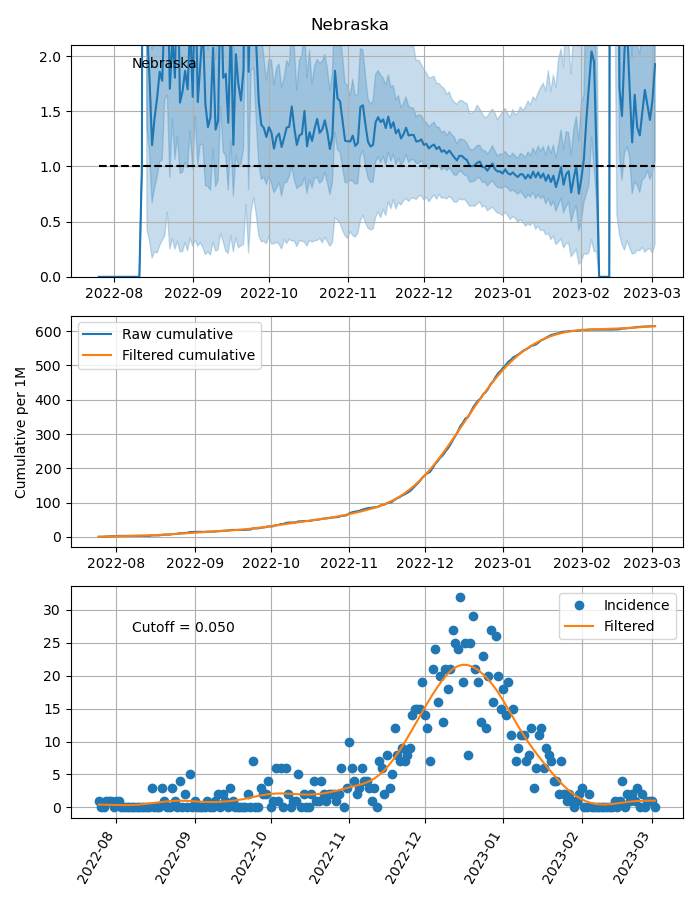

In [5]:
# mcmc.df.columns = state_sr.index

# ---------
# TEST - visualize MCMC feats

state_pop = pop_df.loc[state_name]["population"]

df = mcmc.df.iloc[:, 1:]  # Remove first point, always zero
med = df.quantile(0.500)
qlo = df.quantile(0.025)
qhi = df.quantile(0.975)
q25 = df.quantile(0.250)
q75 = df.quantile(0.750)

fig, axes = plt.subplots(nrows=3, figsize=(7., 9.))

# R(t)
ax = axes[0]
ax.plot(med)
ax.fill_between(med.index, qlo, qhi, color="C0", alpha=0.25)
ax.fill_between(med.index, q25, q75, color="C0", alpha=0.25)
ax.plot(med.index, np.ones_like(med), "k--")
ax.text(0.1, 0.9, state_name, transform=ax.transAxes)
ax.set_ylim(0., 2.1)

# Cumulative
ax = axes[1]
ax.plot(state_sr.cumsum() / state_pop * 1E6, label="Raw cumulative")
ax.plot(prepr_sr.cumsum() / state_pop * 1E6, label="Filtered cumulative")
ax.set_ylabel("Cumulative per 1M")
ax.legend()

# Incidence
ax = axes[2]
ax.plot(state_sr, "o", label="Incidence")
ax.plot(prepr_sr, label="Filtered")
ax.text(0.1, 0.8, f"Cutoff = {cutoff:0.3f}", transform=ax.transAxes)
ax.legend()

# --- General axes setup
for ax in axes:
    ax.grid(True)
    ax.grid(True, which="minor")

fig.suptitle(state_name)
rotate_ax_labels(ax)
fig.tight_layout()

In [21]:
# --------
# ALTERNATIVE PLOT WITH TWINX
# (Requires running the cell above)

fig, ax = plt.subplots(figsize=(7.5, 5.))

axr = ax.twinx()

cumhosp_sr = state_sr.cumsum() / state_pop * 1E6

# R(t)
ax.plot(med)
ax.fill_between(med.index, qlo, qhi, color="C0", alpha=0.25)
ax.fill_between(med.index, q25, q75, color="C0", alpha=0.25)
ax.plot(med.index, np.ones_like(med), "k--")
ax.plot(*calc_one_crossings_toplot(med), "b--", alpha=0.30)
ax.set_ylim(0.0, 2.2)

# Cumulative hosp
axr.plot(cumhosp_sr, label="Raw cumulative", color="C1")
axr.set_ylabel("Cumulative per 1M")
# axr.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
axr.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
# 

fig.suptitle(state_name)
axr.grid(True)
axr.grid(True, which="minor", alpha=0.3)
ax.grid(axis="x")

<IPython.core.display.Javascript object>

In [49]:
# Quickly find all R = 1 crossings
# trhesh = med.loc[]

ft = (med - 1.0)
mask = (ft.iloc[1:].values * ft.iloc[:-1].values) < 0.  # Find changes in signal of f(t) = R(t) - 1
mask_sr = pd.Series(mask, index=ft.index[1:])  # Takes the day following a zero-crossing
crossing_dates = mask_sr.loc[mask_sr].index

fig, ax = plt.subplots()

ax.plot()

xpts = np.repeat(crossing_dates.to_numpy()[np.newaxis, :], 2, axis=0)
ypts = np.repeat([[0.5,], [2.0,]], crossing_dates.shape[0], axis=1)
# ypts = np.repeat([[0.5, 2.0]], crossing_dates.shape[0], axis=0)

# ax.plot(ft.iloc[1:] * ft.iloc[:-1])
# ax.plot(med - 1.0)
ax.plot(xpts, ypts, "b--", alpha=0.30)

NameError: name 'med' is not defined

In [30]:
# --------
# "LEGIT" R(T) = 1 CROSSING: take that with maximum filtered incidence


crossings = calc_one_crossings(med)

if crossings.shape[0] == 0:  # No crossings by the median - take maximum incidence
    result = prepr_sr.idxmax()

else:  # At least one crossing - take that with largest incidence
    result = prepr_sr.loc[crossings].idxmax()
    
    
    
cumhosp_sr.loc[result]

372.75388124985994

# Virological data – just a look

In [40]:
# ------------------
# VIROLOGICAL SURVEILANCE DATA - Just a glance...
# -------------------

# --- From CDC online
# NOTICE: phl[XX] gives past snapshots 
# url = "https://www.cdc.gov/flu/weekly/weeklyarchives2022-2023/data/whoAllregt_phl21.html"  

# --- Local saved
url = "ext_data/INFLUENZA Isolates Data Table Week 19, Season 2022-2023.html"
# url = "ext_data/INFLUENZA Isolates Data TableWeek 39, Season 2021-2022.html"

# url = "ext_data/INFLUENZA Isolates Data Table Week 19, Season 2022-2023.html"
tablist = pd.read_html(url, index_col=0)

tablist[0]

A(H3N2v)  A (H1N1)pdm09  A(H3)  A(unable to sub-type)  \
Week                                                            
202240         0             39    239                      0   
202241         0             66    364                      0   
202242         1            114    448                      0   
202243         0            230    700                      0   
202244         0            316    903                      0   
202245         0            322   1181                      0   
202246         0            443   1557                      0   
202247         0            461   1835                      0   
202248         0            646   2082                      0   
202249         0            547   1993                      0   
202250         0            533   1716                      0   
202251         0            456   1195                      0   
202252         0            443    848                      0   
202301         0            398    822                      0   
202302         0            223    527                      0   
202303         0            209    323                      0   
202304         0            123    165                      0   
202305         0            121    118                      0   
202306         0            131    115                      0   
202307         0             85     69                      0   
202308         0             61     60                      0   
202309         0             74     53                      0   
202310         0             75     44                      0   
202311         0             58     28                      0   
202312         0             60     38                      0   
202313         0             55     16                      0   
202314         0             64     15                      0   
202315         0             42      6                      0   
202316         0             29     12                      0   
202317         0             36     15                      0   
202318         0             30      9                      0   
202319         0             11      1                      0   

        A(Subtyping not performed)   B  BVIC  BYAM  Total # Tested  
Week                                                                
202240                          19   3     5     0            9120  
202241                          23   3     5     0            8513  
202242                          34   4     6     0            9396  
202243                          52   2     3     0            9425  
202244                         179   4     5     0           10288  
202245                         197   1     2     0            9479  
202246                         339   4     2     0           11439  
202247                         384   1     2     0            9795  
202248                         697   1     3     0           12420  
202249                         616   2     4     0           11800  
202250                         578   1     4     0           11443  
202251                         492   3     6     0            9446  
202252                         272   0     7     0            8097  
202301                         242   2    12     0            8708  
202302                         105   1    13     0            8318  
202303                          76   4    12     0            7494  
202304                          42   0    10     0            6772  
202305                          24   2    18     0            6153  
202306                          24   6    21     0            7274  
202307                          18   3    26     0            7331  
202308                          17   4    14     0            6671  
202309                          13   8    28     0            7117  
202310                          14  10    21     0            6891  
202311                           8   9    25     0            6182  
202

<IPython.core.display.Javascript object>


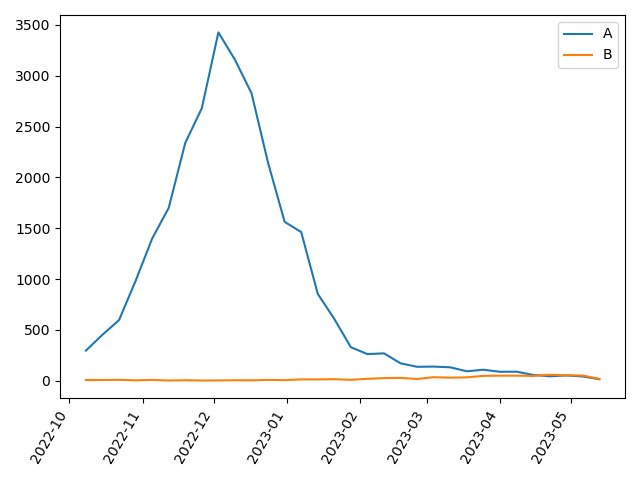

In [41]:
# ---------------------
# PLOT SOME DATA
# ---------------------
df = tablist[0].copy()

# Convert the index to end-of-weeks
# ---------------------------------
index = df.index.astype(str)
index = index.map(lambda s: pd.Timestamp(epiweeks.Week.fromstring(s).enddate()))
index.name = "enddate"

df.index = index

# Sum each subvariant 
# -------------------
df["A"] = df[["A(H3N2v)", "A (H1N1)pdm09", "A(H3)", "A(unable to sub-type)", "A(Subtyping not performed)"]].sum(axis=1)
df["B"] = df[["B", "BVIC", "BYAM"]].sum(axis=1)

# Plot
# ----
fig, ax = plt.subplots()

for label in ["A", "B"]:
    ax.plot(df[label], label=label)
    
ax.legend()
rotate_ax_labels(ax)
fig.tight_layout()

## Metrics and plots from `calc_season_stats.py`

In [13]:
pop_df = pd.read_csv("population_data/locations.csv", index_col=2)  # Col 2 = location_name
metrics_df = pd.read_csv(
    "season_outputs/scalar_metrics.csv", index_col=0, 
    parse_dates=["peak_date", "max_inc_date", "outb_start_date", "raw_max_inc_date"])

metrics_df["abbreviation"] = pop_df["abbreviation"].loc[metrics_df.index]  # Include state abbreviations

metrics_df

print(f"Metrics = {metrics_df.columns}")
# metrics_df

Metrics = Index(['population', 'sum_hosp', 'rel_attack_rate', 'peak_date', 'peak_inc',
       'peak_cum_inc', 'rel_peak_cum_inc', 'peak_method', 'outb_start_date',
       'max_inc_date', 'max_inc', 'raw_max_inc_date', 'raw_max_inc',
       'abbreviation'],
      dtype='object')


In [7]:
# -----------------------------
# SIMPLE LINEAR PLOTS OF SAMPLE VALUES
# -----------------------------

fig, axes = plt.subplots(nrows=2, figsize=(8, 8))

# Attack rate
ax = axes[0]
ax.plot(1E6 * metrics_df["rel_attack_rate"].sort_values(inplace=False), "o")
ax.set_ylabel("Hospitaliz. attack rate (per 1M)")
ax.grid(which="major", axis="x")
rotate_ax_labels(ax, 70)

# Cumulative at peak
ax=axes[1]
ax.plot(1E6 * metrics_df["rel_peak_cum_inc"].sort_values(inplace=False), "o")
ax.set_ylabel("Cumulative hosp. at peak (per 1M)")
ax.grid(which="major", axis="x")
rotate_ax_labels(ax, 70)

fig.tight_layout()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


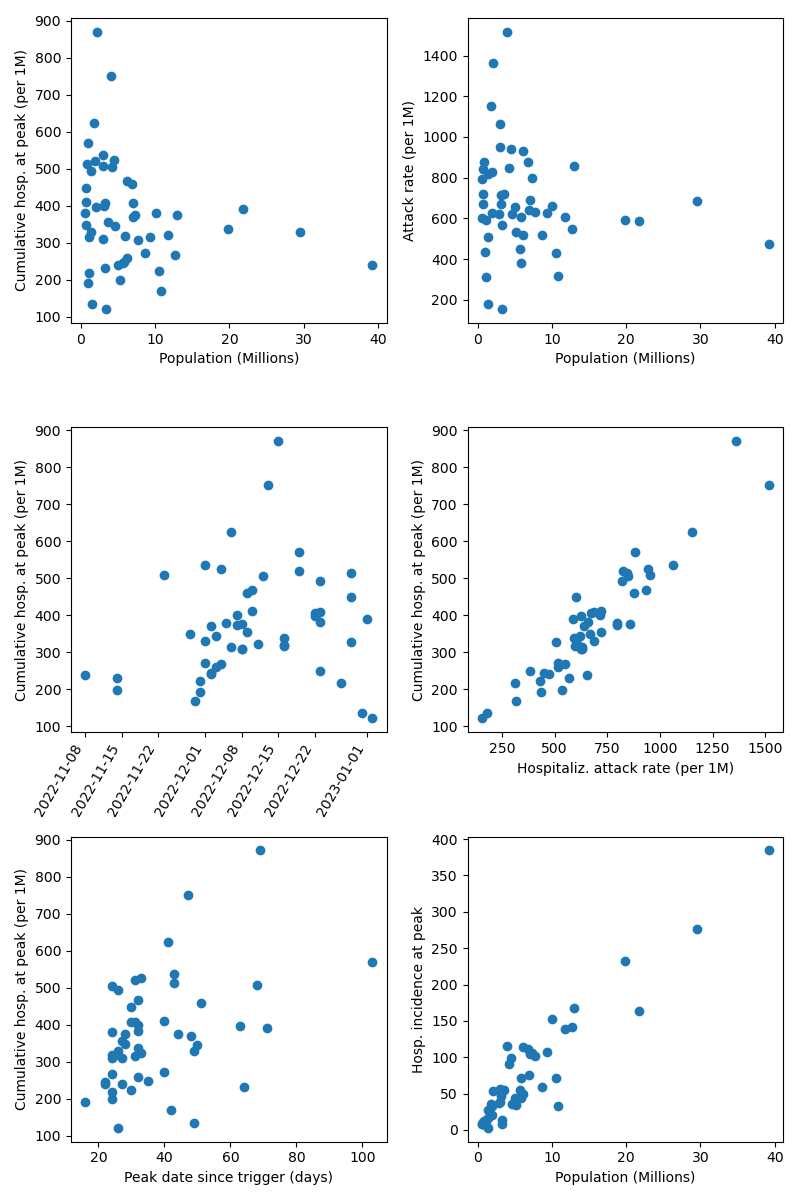

In [16]:
# ---------------------------
# SCATTERPLOTS
# ---------------------------

rscale = 1E6  # Rescale population by this factor
# -------

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 12))

# Cumulative hosp. at peak _vs_ population
ax = axes[0, 0]
ax.scatter(metrics_df["population"] / rscale, rscale * metrics_df["rel_peak_cum_inc"])
ax.set_xlabel("Population (Millions)")
ax.set_ylabel("Cumulative hosp. at peak (per 1M)")

# Attack rate peak _vs_ population
ax = axes[0, 1]
ax.scatter(metrics_df["population"] / rscale, rscale * metrics_df["rel_attack_rate"])
ax.set_xlabel("Population (Millions)")
ax.set_ylabel("Attack rate (per 1M)")

# Cumulative hosp at peak _vs_ peak date
ax = axes[1, 0]
ax.scatter(metrics_df["peak_date"], rscale * metrics_df["rel_peak_cum_inc"])  # Absolute date
rotate_ax_labels(ax)
ax.set_ylabel("Cumulative hosp. at peak (per 1M)")

# Attack rate: Total _vs_ peak
ax = axes[1, 1]
ax.scatter(rscale * metrics_df["rel_attack_rate"], rscale * metrics_df["rel_peak_cum_inc"])
ax.set_xlabel("Hospitaliz. attack rate (per 1M)")
ax.set_ylabel("Cumulative hosp. at peak (per 1M)")

# Cumulative hosp at peak _vs_ peak relative date (since trigger)
ax = axes[2, 0]
ax.scatter(
    (metrics_df["peak_date"] - metrics_df["outb_start_date"]) / np.timedelta64(1, 'D'), 
    rscale * metrics_df["rel_peak_cum_inc"])  # Since "trigger"
ax.set_xlabel("Peak date since trigger (days)")
ax.set_ylabel("Cumulative hosp. at peak (per 1M)")

# Cumulative hosp at peak _vs_ peak relative date (since trigger)
ax = axes[2, 1]
ax.scatter(
    metrics_df["population"] / rscale, 
    metrics_df["peak_inc"])  # Since "trigger"
    
ax.set_xlabel("Population (Millions)")
ax.set_ylabel("Hosp. incidence at peak")


fig.tight_layout()

In [38]:
# -------------------
# SORTED MAX INCIDENCE DATE
# -------------------

label = "max_inc_date"  # Abs. maximum from filtered data
# label = "raw_max_inc_date"  # Abs. maximum in raw data

# -----

sr = metrics_df[label].sort_values()

fig, ax = plt.subplots(figsize=(9, 4))

ax.plot(sr, "o")
ax.set_ylabel("Peak date")
ax.grid(which="major", axis="x")
ax.text(0.20, 0.80, f"Feature = \"{label}\"", transform=ax.transAxes)
rotate_ax_labels(ax, 60)

fig.tight_layout()


# Visualization in a map
# ----------------------
# Preprocess – Convert peak week to a numeric value (days since minimum)
df = metrics_df.copy()
df["Peak days since first"] = (df[label] - df[label].min()) / pd.Timedelta("1d")

# From: https://towardsdatascience.com/simplest-way-of-creating-a-choropleth-map-by-u-s-states-in-python-f359ada7735e
pxfig = px.choropleth(
    df,
    locations="abbreviation",
    locationmode="USA-states",
#     color="Peak days since first",
    color="rel_peak_cum_inc",
    scope="usa",  # Focus the map
)

pxfig.show()


<IPython.core.display.Javascript object>

--------

# R(t) estimation over time

MCMC R(t) estimation using the available data in each week.

This section runs independently of the previous ones

In [2]:
# -----------------
# PARAMETERS
# -----------------
loc_name = "Florida"

start_date, end_date = "2022-10-23", "2023-05-07"
mcmc_folder = "preproc/2022-2023_buffer/cutoff0p10/mcmc_outputs/"


# IMPORTS
# -----------------
from rtrend_forecast.rt_estimation import RtData
from rtrend_interface.parsel_utils import make_file_friendly_name

dates = pd.date_range(start_date, end_date, freq="1w")

rt_list = list()

print("Loading...")
for date in dates:
    fname = os.path.join(mcmc_folder, date.date().isoformat(), f"{make_file_friendly_name(loc_name)}_rt.out")
    if os.path.exists(fname):
        rt_list.append(RtData(np.loadtxt(fname), fname))
    else:
        print(f"Not found: {fname}")
        rt_list.append(None)
        
print(f"{len(rt_list)} of {len(dates)} loaded.")

# Make a pandas object series with each MCMC 
rt_sr = pd.Series(rt_list, index=dates)

Loading...
29 of 29 loaded.
